# **Comparison with other TCR clustering methods**
This notebook compares the clustering quality of *clusTCR* with existing TCR clustering methods and can be used to recreate the paper's figures. To use the notebook, clone *clusTCR*'s github repository ([https://github.com/svalkiers/clusTCR](https://github.com/svalkiers/clusTCR)) into a local repository and pasting the path to the repo down here.

In [1]:
import os

# Path to clusTCR repo goes here:
os.chdir('/path_to_repo/clusTCR/')

Import all dependencies

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from clustcr import Clustering, datasets
from clustcr.input.vdjdb import parse_vdjdb
from clustcr.clustering.clustering import ClusteringResult
from clustcr.modules.gliph2.gliph2 import GLIPH2
from clustcr.modules.ismart.ismart import iSMART
from clustcr.modules.tcrdist.pw_tcrdist import TCRDist, cluster_TCRDist_matrix

Set figure aesthetics.

In [3]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')
sns.set_context('paper', font_scale=1.3)

The following utility functions are used downstream during the benchmarking. The `get_chain_data()` function prepares CDR3 and epitope data from the VDJdb. It can be used to generate data specific for **alpha**, **beta** or **paired** chains.

The `join_cdr3_v()` function generates a new identifier for a TCR by joining CDR3 and V columns into a single one. It also removes the existing CDR3 and V columns.

In [4]:
def get_chain_data(chain_name, q=0):

    vdjdb = parse_vdjdb('./clustcr/input/vdjdb/vdjdb_full.txt', q=q)

    if chain_name == 'alpha':
        epitopes = vdjdb.drop(columns=['cdr3.beta', 'v.beta']).dropna().drop_duplicates()
        epitopes = epitopes.rename(columns={'cdr3.alpha':'CDR3','v.alpha':'V','antigen.epitope':'Epitope'})
        chain = epitopes.drop(columns='Epitope').drop_duplicates().reset_index(drop=True)
    elif chain_name == 'beta':
        epitopes = vdjdb.drop(columns=['cdr3.alpha', 'v.alpha']).dropna().drop_duplicates()
        epitopes = epitopes.rename(columns={'cdr3.beta':'CDR3','v.beta':'V','antigen.epitope':'Epitope'})
        chain = epitopes.drop(columns='Epitope').drop_duplicates().reset_index(drop=True)
    else:
        epitopes = vdjdb.dropna().drop_duplicates()
        epitopes = epitopes.rename(columns={'cdr3.beta':'CDR3_beta','v.beta':'V_beta',
                                            'cdr3.alpha':'CDR3_alpha','v.alpha':'V_alpha',
                                            'antigen.epitope':'Epitope'})
        chain = epitopes.drop(columns='Epitope').drop_duplicates().reset_index(drop=True)
        
    return chain, epitopes

def join_cdr3_v(df, data_type='clusters_df'):
    df = df.drop_duplicates()
    joint_id = df['CDR3'] + '_' + df['V']
    df['TCR'] = joint_id
    df = df.drop(columns=['CDR3', 'V'])
    df = df.rename(columns={'TCR':'CDR3'})
    if data_type == 'clusters_df':
        df = df[['CDR3', 'cluster']]
    else:
        df = df[['CDR3', 'Epitope']]
    return df.drop_duplicates()

Next, the analysis is performed. First, start by selecting the TCR chain, then run the benchmarking.

In [ ]:
CHAIN = 'beta'

Run the following code block to perform the benchmark analysis. Several metric are calculated to quantify the quality of the clustering results. These metrics include:
- **Retention:** the number of sequences that end up in any cluster, relative to the total number of input sequences.
- **Purity:** the degree to which sequences in the same cluster target the same antigen.
- **Consistency:** the fraction of sequences, that target the same epitope, that are assigned to the same cluster.

In [25]:
benchmark = pd.DataFrame()

for q in [0,1,2]:
    
    chain_data, epitope_data = get_chain_data(chain_name=CHAIN, q=q)
    
    out = Clustering(n_cpus=8).fit(chain_data.CDR3.drop_duplicates())
    output = out.metrics(epitope_data.drop(columns=['V','subject','count']).drop_duplicates()).summary()
    output['method'] = 'ClusTCR'
    output['q'] = q
    benchmark = benchmark.append(output)
    
    nodes, t = GLIPH2(chain_data)
    nodes = nodes.drop(columns=['motif']).drop_duplicates()
    output = ClusteringResult(nodes).metrics(epitope_data.drop(columns=['V','subject','count']).drop_duplicates()).summary()
    output['method'] = 'GLIPH2'
    output['q'] = q
    benchmark = benchmark.append(output)
    
    os.chdir('/home/sebastiaan/PhD/Repositories/clusTCR/')
    
    ismart_data = chain_data.drop(columns=['subject', 'count'])
    nodes, t = iSMART(ismart_data)
    output = ClusteringResult(join_cdr3_v(nodes)).metrics(join_cdr3_v(epitope_data, data_type='epitope_data')).summary()
    output['method'] = 'iSMART'
    output['q'] = q
    benchmark = benchmark.append(output)
    
    os.chdir('/home/sebastiaan/PhD/Repositories/clusTCR/')
    
    if q == 0:
        pass
    else:
        d, seq, gt = TCRDist(parse_vdjdb('./clustcr/input/vdjdb/vdjdb_full.txt', q=q))
        output = cluster_TCRDist_matrix(d, seq, gt)
        output['method'] = 'TCRDist'
        output['q'] = q
        benchmark = benchmark.append(output)
    
    benchmark.to_csv('./results/method_comparison_accuracy_{}.tsv'.format(CHAIN), index=False, sep='\t')

Finally, use the following block of code to generate the figures from the manuscript.

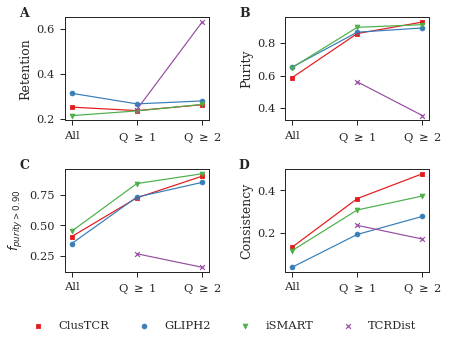

In [11]:
# Import results
benchmark = pd.read_csv('./results/method_comparison_accuracy_{}.tsv'.format(CHAIN), sep='\t')

fig, ax = plt.subplots(nrows=2, ncols=2)

# Set x-axis labels
locs = [0, 1, 2]
labels = ['All', 'Q $\\geq$ 1', 'Q $\\geq$ 2']
plt.setp(ax, xticks=locs, xticklabels=labels),
x = benchmark.q.unique()

isolated_metric = benchmark[benchmark.metrics=='retention']
ax[0,0].plot(x, isolated_metric[isolated_metric.method=='ClusTCR'].actual)
ax[0,0].scatter(x, isolated_metric[isolated_metric.method=='ClusTCR'].actual, marker='s')
ax[0,0].plot(x, isolated_metric[isolated_metric.method=='GLIPH2'].actual)
ax[0,0].scatter(x, isolated_metric[isolated_metric.method=='GLIPH2'].actual, marker='o')
ax[0,0].plot(x, isolated_metric[isolated_metric.method=='iSMART'].actual)
ax[0,0].scatter(x, isolated_metric[isolated_metric.method=='iSMART'].actual, marker='v')
ax[0,0].plot([1,2], isolated_metric[isolated_metric.method=='TCRDist'].actual)
ax[0,0].scatter([1,2], isolated_metric[isolated_metric.method=='TCRDist'].actual, marker='x')
ax[0,0].set_ylabel('Retention')

isolated_metric = benchmark[benchmark.metrics=='purity']
ax[0,1].plot(x, isolated_metric[isolated_metric.method=='ClusTCR'].actual)
ax[0,1].scatter(x, isolated_metric[isolated_metric.method=='ClusTCR'].actual, marker='s')
ax[0,1].plot(x, isolated_metric[isolated_metric.method=='GLIPH2'].actual)
ax[0,1].scatter(x, isolated_metric[isolated_metric.method=='GLIPH2'].actual, marker='o')
ax[0,1].plot(x, isolated_metric[isolated_metric.method=='iSMART'].actual)
ax[0,1].scatter(x, isolated_metric[isolated_metric.method=='iSMART'].actual, marker='v')
ax[0,1].plot([1,2], isolated_metric[isolated_metric.method=='TCRDist'].actual)
ax[0,1].scatter([1,2], isolated_metric[isolated_metric.method=='TCRDist'].actual, marker='x')
ax[0,1].set_ylabel('Purity')

isolated_metric = benchmark[benchmark.metrics=='purity_90']
ax[1,0].plot(x, isolated_metric[isolated_metric.method=='ClusTCR'].actual)
ax[1,0].scatter(x, isolated_metric[isolated_metric.method=='ClusTCR'].actual, marker='s')
ax[1,0].plot(x, isolated_metric[isolated_metric.method=='GLIPH2'].actual)
ax[1,0].scatter(x, isolated_metric[isolated_metric.method=='GLIPH2'].actual, marker='o')
ax[1,0].plot(x, isolated_metric[isolated_metric.method=='iSMART'].actual)
ax[1,0].scatter(x, isolated_metric[isolated_metric.method=='iSMART'].actual, marker='v')
ax[1,0].plot([1,2], isolated_metric[isolated_metric.method=='TCRDist'].actual)
ax[1,0].scatter([1,2], isolated_metric[isolated_metric.method=='TCRDist'].actual, marker='x')
ax[1,0].set_ylabel(r'$f_{purity > 0.90}$')

isolated_metric = benchmark[benchmark.metrics=='consistency']
ax[1,1].plot(x, isolated_metric[isolated_metric.method=='ClusTCR'].actual)
ax[1,1].scatter(x, isolated_metric[isolated_metric.method=='ClusTCR'].actual, marker='s', label='ClusTCR')
ax[1,1].plot(x, isolated_metric[isolated_metric.method=='GLIPH2'].actual)
ax[1,1].scatter(x, isolated_metric[isolated_metric.method=='GLIPH2'].actual, marker='o', label='GLIPH2')
ax[1,1].plot(x, isolated_metric[isolated_metric.method=='iSMART'].actual)
ax[1,1].scatter(x, isolated_metric[isolated_metric.method=='iSMART'].actual, marker='v', label='iSMART')
ax[1,1].plot([1,2], isolated_metric[isolated_metric.method=='TCRDist'].actual)
ax[1,1].scatter([1,2], isolated_metric[isolated_metric.method=='TCRDist'].actual, marker='x', label='TCRDist')
ax[1,1].set_ylabel('Consistency')

ax[0,0].text(-0.25, 1.1, 'A', transform=ax[0,0].transAxes, fontweight='bold', va='top', ha='right')
ax[0,1].text(-0.25, 1.1, 'B', transform=ax[0,1].transAxes, fontweight='bold', va='top', ha='right')
ax[1,0].text(-0.25, 1.1, 'C', transform=ax[1,0].transAxes, fontweight='bold', va='top', ha='right')
ax[1,1].text(-0.25, 1.1, 'D', transform=ax[1,1].transAxes, fontweight='bold', va='top', ha='right')

handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles, labels, ncol=4, loc='lower right', bbox_to_anchor=(.94, -.1))

fig.tight_layout()
fig.savefig('./results/figures/method_comparison_accuracy_{}.eps'.format(CHAIN), format='eps', bbox_inches='tight')